# Photometry

On this page we'll detect sources and perform simple aperture photometry (along other measurements) for each pre-reduced image.
The same procedure could of course also be applied to coadded images.

As before, you could copy or write the code shown below in a script, or alternatively directly download this page as a {download}`jupyter notebook <./photometry.ipynb>` file.

To run the code, you'll need the module `dataredconfig.py`, as explained [here](./data.md).

```{note}
The photometry presented here is sufficient for our purposes, but remains extremely simple. Notably, it ignores the effect of variable seeing (in time and/or accross filters). The next steps to improve upon the minimal approach shown here would be to perform a PSF homogeneization or to use PSF-fitting.
```

In [1]:
import dataredconfig
from pathlib import Path

import numpy as np
import astropy
import astropy.visualization
from astropy import units as u

%matplotlib widget
import matplotlib
from matplotlib import pyplot as plt

import ccdproc
import photutils.background
import photutils.aperture
import photutils.segmentation
import photutils.psf

from scipy.ndimage import gaussian_filter

from time import time


In [2]:
# We'll ignore some astropy warnings that get raised as our FITS headers (from NINA) are not 100% standards compliant.
import warnings
warnings.simplefilter('ignore', category=astropy.wcs.FITSFixedWarning)

In [3]:

# Setting the correct path to the pre-reduced science frames to work on:
#science_files_dir = dataredconfig.work_dir / "LIGHT_PRERED" # In case astrometric calibration was already performed before the pre-reduction
science_files_dir = dataredconfig.work_dir / "ASTROMETRY"
science_files = ccdproc.ImageFileCollection(science_files_dir, keywords=dataredconfig.ifc_header_keywords)

# Where to write the catalogs:
photometry_dir = dataredconfig.work_dir / "PHOTOMETRY"
photometry_dir.mkdir(exist_ok=True)

# Overview of all available files:
science_files.summary
# You may want to try this instead, for a better display:
#science_files.summary.show_in_notebook()


file,imagetyp,filter,exptime,object,xbinning,ybinning,naxis1,naxis2,DATE-OBS,UTSTART
str35,float64,str1,float64,float64,float64,float64,int64,int64,str10,str8
ngc1672_I_357_2024_00005-23231.fits,--,I,60.0,--,--,--,4096,4096,2024:12:22,07:13:43
ngc1672_I_357_2024_00006-23232.fits,--,I,60.0,--,--,--,4096,4096,2024:12:22,07:15:03
ngc1672_I_357_2024_00007-23233.fits,--,I,60.0,--,--,--,4096,4096,2024:12:22,07:16:22
ngc1672_I_357_2024_00008-23234.fits,--,I,60.0,--,--,--,4096,4096,2024:12:22,07:17:41
ngc1672_I_357_2024_00009-23235.fits,--,I,60.0,--,--,--,4096,4096,2024:12:22,07:18:58
ngc1672_R_357_2024_00000-23221.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:52:56
ngc1672_R_357_2024_00001-23222.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:54:16
ngc1672_R_357_2024_00002-23223.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:55:35
ngc1672_R_357_2024_00003-23224.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:56:56


In [4]:
# Optional: selecting the science frames to run on : 
#object_to_process = "HD92670"

science_files = science_files.filter(naxis1=4096)

science_files.summary

file,imagetyp,filter,exptime,object,xbinning,ybinning,naxis1,naxis2,DATE-OBS,UTSTART
str88,float64,str1,float64,float64,float64,float64,int64,int64,str10,str8
/export/data1/fprak2/.testsmt/UBC/workdir/ASTROMETRY/ngc1672_I_357_2024_00005-23231.fits,--,I,60.0,--,--,--,4096,4096,2024:12:22,07:13:43
/export/data1/fprak2/.testsmt/UBC/workdir/ASTROMETRY/ngc1672_I_357_2024_00006-23232.fits,--,I,60.0,--,--,--,4096,4096,2024:12:22,07:15:03
/export/data1/fprak2/.testsmt/UBC/workdir/ASTROMETRY/ngc1672_I_357_2024_00007-23233.fits,--,I,60.0,--,--,--,4096,4096,2024:12:22,07:16:22
/export/data1/fprak2/.testsmt/UBC/workdir/ASTROMETRY/ngc1672_I_357_2024_00008-23234.fits,--,I,60.0,--,--,--,4096,4096,2024:12:22,07:17:41
/export/data1/fprak2/.testsmt/UBC/workdir/ASTROMETRY/ngc1672_I_357_2024_00009-23235.fits,--,I,60.0,--,--,--,4096,4096,2024:12:22,07:18:58
/export/data1/fprak2/.testsmt/UBC/workdir/ASTROMETRY/ngc1672_R_357_2024_00000-23221.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:52:56
/export/data1/fprak2/.testsmt/UBC/workdir/ASTROMETRY/ngc1672_R_357_2024_00001-23222.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:54:16
/export/data1/fprak2/.testsmt/UBC/workdir/ASTROMETRY/ngc1672_R_357_2024_00002-23223.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:55:35
/export/data1/fprak2/.testsmt/UBC/workdir/ASTROMETRY/ngc1672_R_357_2024_00003-23224.fits,--,R,60.0,--,--,--,4096,4096,2024:12:22,06:56:56


We will measure photometry on all these files.
But we start by picking one reference image, used to detect sources. It should be a good and deep exposure. We will also use this same image to check the overall procedure.

Note that it doesn't have to be the first one. Select another index below if your first image is bad for some reason. 

In [5]:
ref_image_filepath = science_files.files[0]

print(ref_image_filepath)

ref_image = ccdproc.CCDData.read(ref_image_filepath)

if(ref_image.wcs is None): # Performing forced photometry requires each frame to have a good WCS. This test is just to avoid obvious mistakes.
    raise RuntimeError("The image has no WCS, make sure you specify the correct directory (i.e., with WCS) above!")


/export/data1/fprak2/.testsmt/UBC/workdir/ASTROMETRY/ngc1672_I_357_2024_00005-23231.fits


## Estimating and subtracting the background

The background estimation is run individually on every image (as the background might well change, e.g., due to clouds, light pollution, or stray light). We therefore start by defining a function for background estimation.
Depending on the data to be processed, you might have to adjust the parameters of this function, to tune the "flexibility" of the background model to your science objective. The given default values are often ok, but certaintly not optimal for every situation. 

The typical compromise in background estimation is driven by the following. If the background model is too flexible, the background subtraction will take away some light from larger objects (such as galaxies, but also the central regions of star clusters). And if it is to rigid, the model won't be able to properly fit the structure that the background might have.  

In [11]:
def estimate_background(image, box_size=500, filter_size=4):
    """Function to estimate the background and its RMS (root-mean-square deviation).
    This is a simplifying wrapper around photutils, to expose and explain a bit the two key parameters box_size and filter_size.
    
    In short, the background is calculated by interpolating some sigma-clipped statistics evaluated on a relatively coarse grid.

    Parameters:
    image: a CCDData object
    box_size: defines how fine the coarse grid is, in pixels.
        The background gets estimated in each box of size box_size.
        Ideally this is larger than the largest obects, but smaller than the background structure.
    filter_size: an odd integer: window size of the median filter that gets applied to the measurements on the coarse grid.
        This median filter helps for example to avoid "bumps" from large diffuse objects. 

    For more details, see https://photutils.readthedocs.io/en/stable/user_guide/background.html
    
    Returns:
    background, background_rms: two numpy arrays
    """
    
    bkg = photutils.background.Background2D(
        image.data,
        box_size=(box_size, box_size),
        filter_size=(filter_size, filter_size),
        bkg_estimator=photutils.background.MedianBackground()
        )
    
    return bkg.background, bkg.background_rms


Let's apply this to the reference image, to experiment with the parameters. 

If the background you want to subtract has relatively fine structures, try reducing box_size and simultaneouly increasing filter_size in the call below. 

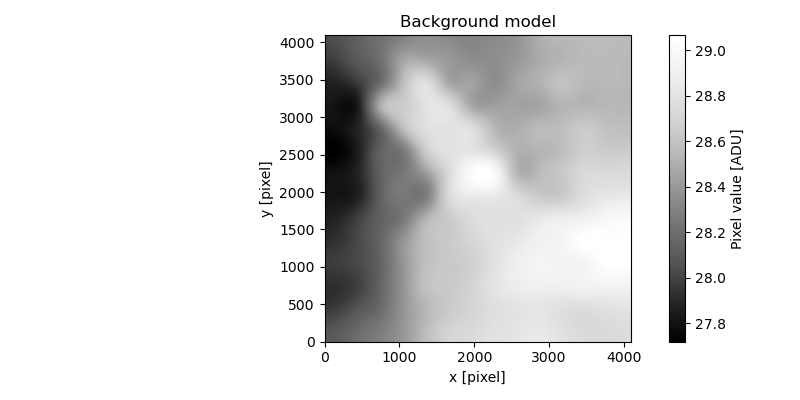

In [12]:
# We run this on the reference image
background_box_size = 300
background_filter_size = 3
background, background_rms = estimate_background(ref_image, box_size=background_box_size, filter_size=background_filter_size)

# Visualize the background image
plt.figure(figsize=(8, 4))
plt.title("Background model")
cbar = plt.imshow(background, origin='lower', cmap='Greys_r', interpolation='nearest')
plt.colorbar(cbar, label="Pixel value [ADU]")
plt.xlabel("x [pixel]")
plt.ylabel("y [pixel]")
plt.tight_layout()
plt.show()

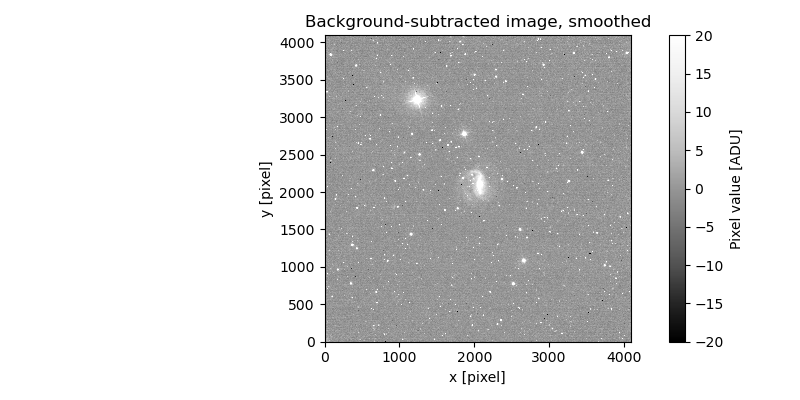

In [13]:
# We subtract the background from the reference image
ref_image_noback = ref_image.subtract(ccdproc.CCDData(background, unit="adu"))

# And visualize how "flat" the background-subtracted reference image is.
# We smooth this slightly, to reduce noise and better see the structure.
plt.figure(figsize=(8, 4))
plt.title("Background-subtracted image, smoothed")
cbar = plt.imshow(gaussian_filter(ref_image_noback.data, sigma=3.0), origin='lower', cmap='Greys_r', interpolation='nearest', vmin=-20, vmax=20)
plt.colorbar(cbar, label="Pixel value [ADU]")
plt.xlabel("x [pixel]")
plt.ylabel("y [pixel]")
plt.tight_layout()
plt.show()

The above two visualizations will probably never look perfect, as background subtraction is difficult (way more sophisticated approaches exist). Explore if you can improve it by adjusting the background estimation parameters, otherwise keep the default values.

In preparation for the source detection, we also have to define a "threshold" image for this reference frame, whose values are multiples of the estimated RMS of the background in each pixel.

In [14]:
# (RMS is an estimate of the standard deviation, so 3*RMS is "3 sigma" above the background)
threshold = 3.0 * background_rms # this is an array

## Source detection and measurement

We now detect sources (as groups of connected pixels above the threshold) and measure their exact positions (among other parameters), on the selected reference image. Let's nevertheless group all this in a function again.

In [15]:
def detect_and_measure(image, threshold):
    """Function to detect and measure sources.
    This is close to what Source Extractor typically does.
    
    Parameters:
    image: a CCDData object
    threshold: a 2D-array with threshold values

    Returns:
    An Astropy Table with source positions (from  windowed centroids, 
    both in pixel and sky coordinates) and other measurements.
    """
    data = image.data 

    # Filtering (convolving with a 2D Gaussian) for better source detection
    kernel = photutils.segmentation.make_2dgaussian_kernel(fwhm=4.0, size=21)  # FWHM in pixels
    convolved_data = astropy.convolution.convolve(data, kernel)

    # Segmenting the image
    finder = photutils.segmentation.SourceFinder(npixels=4, connectivity=4, progress_bar=False)
    segment_map = finder(convolved_data, threshold)
    #segment_map = finder(data, threshold) # One could also run this on the unfiltered image

    # And measuring sources
    source_catalog = photutils.segmentation.SourceCatalog(data, segment_map, convolved_data=convolved_data, wcs=image.wcs)
    source_table = source_catalog.to_table(
        columns=["xcentroid_win", "ycentroid_win", "sky_centroid_win",
                 "fwhm", "max_value", "kron_flux", "segment_flux", "segment_area"]
        )

    return astropy.table.Table(source_table) # We convert the QTable to a Table, better for later FITS writing.

In [16]:
# Run this on the reference image
ref_catalog = detect_and_measure(ref_image_noback, threshold)

print(f"Reference catalog: {len(ref_catalog)} sources detected.")

Reference catalog: 618 sources detected.


After running a detection, it's almost mandatory to check the result with a visualization! We do this with the following interactive Figure.

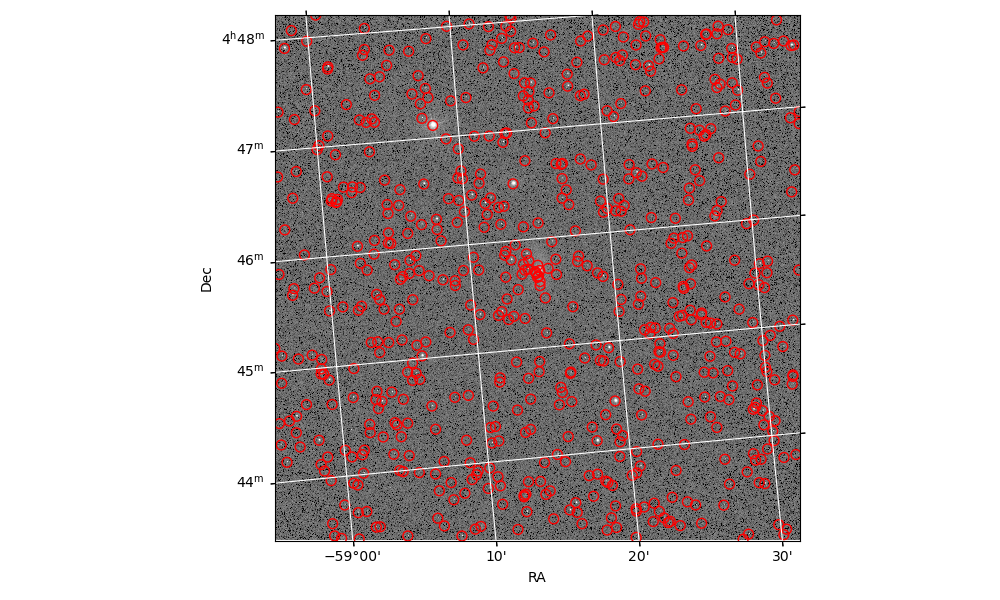

In [17]:
# Figure that overplots the image and the positions of the detected sources

plt.figure(figsize=(10, 6))
ax = plt.subplot(projection=ref_image_noback.wcs)
ax.imshow(ref_image_noback.data, origin='lower', cmap='Greys_r', interpolation='nearest',
    norm=astropy.visualization.simple_norm(ref_image_noback.data, stretch="log", vmin=-20, vmax=2000))
ax.scatter(
    ref_catalog["xcentroid_win"],
    ref_catalog["ycentroid_win"],
    transform=ax.get_transform('pixel'),
    s=50, # The size of these markers is not related to any measurement apertures!
    edgecolor='red', facecolor='none'
    )
ax.grid(color='white', ls='solid')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.tight_layout()
plt.show()

Zoom in and check if all relevant sources are detected. If there are issues, one might have to adjust the sensitivity of the detection.

Depending on your science objective, you can save CPU-time by setting a flux threshold to keep only those stars you actually care about, and not every tiny detection.

In [18]:
# Apply some flux cut, to remove fainter sources if those are not needed:
ref_catalog = ref_catalog[ref_catalog["kron_flux"] > 1000]
len(ref_catalog)

# Now rerun the vizualisation above to see the effect, and adapt the threshold if needed!

601

In [19]:
# For reference, we write the reference catalog in this directory.
# Note that this catalog also contains the aperture positions in sky coordinates.
ref_catalog.write(photometry_dir / f"ref_catalog.fits", overwrite=True)

## Forced aperture photometry

We'll now perform forced aperture photometry on all science images of our target, with a series of aperture sizes (radii given in arcseconds in the code below).
This means that we use the sky coordinates of the sources detected in the reference frame to place the same apertures on all dithered exposures of the target.

In [20]:
# We group all steps of the photometric measurement into one function:

def measure_photometry(image, sky_positions, run_simple_fit=False, background_box_size=300, background_filter_size=3):
    """Function for forced aperture photometry given the provided sky_positions.
    This function first estimates and subtracts the background from the image,
    and performs aperture photometry both on the background-subtracted image and on the background alone.

    Parameters:
    image: a CCDData object
    sky_positions: a list or column of aperture positions, in sky coordinates (i.e. as SkyCoord objects)
    run_fit: if True, a simple 2D Gaussian fit is also run, providing FWHM and flux measurements. Take significantly more time.

    Returns:
    An Astropy Table with measurements for several aperture radii at the given positions.
    """

    # Estimating and subtracting the background:
    tstart = time()    
    background, _ = estimate_background(image, box_size=background_box_size, filter_size=background_filter_size)
    image_noback = image.subtract(ccdproc.CCDData(background, unit="adu"))
    tend = time()
    print(f"Background subtraction took {tend-tstart:.2f} sec")
    
    
    # Aperture photometry
    aperture_radii = [4, 6, 8, 10] # In arcsec
    tstart = time()
    # We generate a separate catalog for each aperture radius, and combine these afterwards
    aperture_catalogs = []
    for r in aperture_radii:

        apertures = photutils.aperture.SkyCircularAperture(sky_positions, r=r*u.arcsec)

        # Photometry on the background-subtracted image:
        aperture_measurements = photutils.aperture.ApertureStats(image_noback.data, aperture=apertures, wcs=image_noback.wcs)
        # Same photometry on the background image:
        background_aperture_measurements = photutils.aperture.ApertureStats(background.data, aperture=apertures, wcs=image_noback.wcs)
        
        aperture_catalog = aperture_measurements.to_table(columns=["sum", "max"])
        background_aperture_catalog = background_aperture_measurements.to_table(columns=["sum"])

        # Note: ApertureStats also provides "fwhm" and "elongation", among other stats.
        # While these measurements are fast and can be useful, they are computed from unweighted moments,
        # and will therefore be strongly influenced by the aperture size and the noise.
        # Just for reference, this is how to get them:
        #aperture_catalog = aperture_measurements.to_table(columns=["fwhm", "elongation", "sum"])        

        # Rename columns by adding the aperture radius, to get for example "sum_4" instead of sum
        for name in aperture_catalog.colnames:
            aperture_catalog.rename_column(name, new_name=f"{name}_{str(r)}")
        for name in background_aperture_catalog.colnames:
            background_aperture_catalog.rename_column(name, new_name=f"back_{name}_{str(r)}")
         
        aperture_catalogs.append(aperture_catalog)
        aperture_catalogs.append(background_aperture_catalog)
    
    # And now merge these catalogs into a single one:
    merged_catalog = astropy.table.hstack(aperture_catalogs,
        join_type="exact", metadata_conflicts="silent"
        )
    tend = time()
    print(f"Photometry took {tend-tstart:.2f} sec")


    # Optional simple 2D Gaussian fit for FWHM-measurement of sources:
    if run_simple_fit:
        tstart = time() 
        # Compute pixel-coordinate positions of the positions:
        image_pixel_positions = astropy.wcs.utils.skycoord_to_pixel(sky_positions, image_noback.wcs)
        xypos = np.array(image_pixel_positions).transpose() # Rearranging the data
        # Add empty columns to hold the measurements:
        merged_catalog.add_columns([np.nan, np.nan, np.nan], names=["fwhm_fit", "flux_fit", "q_fit"])
        # And loop over the sources.
        # We need this loop as some sources might be outside of a particular exposure, raising exceptions.
        for (i, pos) in enumerate(xypos):
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    fit_results = photutils.psf.fit_2dgaussian(image_noback.data, xypos=pos, fit_shape=15, fwhm=6, fix_fwhm=False).results
                    merged_catalog["fwhm_fit"][i] = fit_results["fwhm_fit"][0]
                    merged_catalog["flux_fit"][i] = fit_results["flux_fit"][0]
                    merged_catalog["q_fit"][i] = fit_results["qfit"][0]
            except Exception as e:
                print(f"Fit failed for source {i}")
        tend = time()
        print(f"2D Gaussian fitting took {tend-tstart:.2f} sec")

    return merged_catalog


In [21]:

# As a test, we run this on the ref_image.
# For this we read the ref image again, as the one in memory already has the background subtracted.
ref_image = ccdproc.CCDData.read(ref_image_filepath)
ref_photo_cat = measure_photometry(ref_image, ref_catalog["sky_centroid_win"],
                                   run_simple_fit=True,
                                   background_box_size = background_box_size,
                                   background_filter_size = background_filter_size
                                   )
print(ref_photo_cat.colnames)

Background subtraction took 2.25 sec
Photometry took 0.38 sec
2D Gaussian fitting took 10.35 sec
['sum_4', 'max_4', 'back_sum_4', 'sum_6', 'max_6', 'back_sum_6', 'sum_8', 'max_8', 'back_sum_8', 'sum_10', 'max_10', 'back_sum_10', 'fwhm_fit', 'flux_fit', 'q_fit']


To summarize, the columns are the following.
 - `sum_x` is the background-subtracted flux within the aperture of radius `x` arcsec. This is what we'll use to compute magnitudes.
 - `max_x` is the maximum pixel value within the corresponding aperture. This informs us if some pixels are at or close to saturation.
 - `back_sum_x` is the flux of the background within the corresponding aperture. This could be used later to estimate the noise of the photometry.
 - `fwhm_fit`, `flux_fit`, `q_fit` are measurements from the optional 2D Gaussian fit.

### Size-magnitude diagram

As an illustration of how this photometric catalog can be used, we create a basic and very common scatter plot of the measured FWHM against instrumental (i.e., uncalibrated) magnitude of all detected sources. This diagram is sometimes called "chimney plot", after its shape.

```{note} 
Potentially, your image contains both unresolved sources (stars) and resolved sources (e.g., galaxies). If your image is relatively well focused and has enough sources, this plot should show you a clear "stellar locus" (this is the "chimney", where the stars are), which directly shows you the seeing of this particular image. Can you measure it? A potential fine "smoke plume" rising from your chimney is related to saturation of the brightest stars, which increases their FHWM.
```

Recall that the measured seeing depends on the filter, the focus, and the atmospheric conditions (among other potential issues). It can be interesting to visualize it as function of time.

/tmp/ipykernel_1449290/804801732.py:2: RuntimeWarning: invalid value encountered in log10
  ref_photo_cat["mag_6"] = -2.5 * np.log10(ref_photo_cat["sum_6"].value)


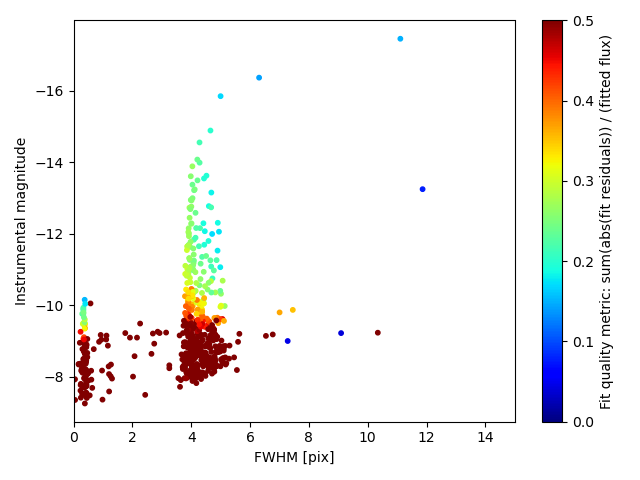

In [22]:
# Just as an example, let's use the flux within the apertures of 6 arcseconds: 
ref_photo_cat["mag_6"] = -2.5 * np.log10(ref_photo_cat["sum_6"].value)

# We create a scatter plot of FWHM versus mag, and color the datapoints according to the q_fit parameter (see legend).
# High values of q_fit indicate that the source was not well fitted by the simple 2D-Gaussian.
plt.figure()
plt.scatter(
    ref_photo_cat["fwhm_fit"].value, 
    ref_photo_cat["mag_6"], 
    c=ref_photo_cat["q_fit"].value,
    vmin=0.0, vmax=0.5,
    cmap="jet",
    s=10
)
plt.gca().invert_yaxis() # Bright is at the top!
plt.colorbar(label="Fit quality metric: sum(abs(fit residuals)) / (fitted flux)")
plt.xlabel("FWHM [pix]")
plt.xlim(0, 15)
plt.ylabel("Instrumental magnitude")
plt.tight_layout()
plt.show()

### Performing the measurements on all images 

Finally, we apply this measurement function to all images of the object.

If you *don't* need the Gaussian fitting (which provides `fwhm_fit`), you can run this faster by leaving `run_simple_fit=False` below, in the call of `measure_photometry()`. Otherwise just set it to `True`.

In [26]:
# We read again the ref catalog from file:
ref_catalog = astropy.table.Table.read(photometry_dir / f"ref_catalog.fits")


n_files = len(science_files.summary)
# And now we loop over all selected exposures:
for (i, science_file) in enumerate(science_files.files):

    image_filename = Path(science_file).stem
    output_filepath = photometry_dir / f"{image_filename}.fits"

    # Could use something like that to relaunch on new or selected files:
    #if output_filepath.exists():
    #    continue
    # Or, alternatively:
    #if i < 104:
    #    continue
    
    print(f"=== Processing image {i+1}/{n_files}: {image_filename} ===")

    image = ccdproc.CCDData.read(science_file)

    # We build a dict containing some meta-information of the image taken from the FITS header.
    # We'll later write this as meta-information of the catalogue.
    meta_from_image = {key: image.header[key] for key in [
        "DATE-OBS", "EXPTIME", "UTSTART", "MJD-OBS", "DOY", "FILTER"
        ]}
    
    # Now run the measurements:
    catalog = measure_photometry(image, ref_catalog["sky_centroid_win"],
                                 run_simple_fit=True,
                                 background_box_size = background_box_size,
                                 background_filter_size = background_filter_size
                                 )

    # Add the information from the FITS header
    catalog.meta.update(meta_from_image)

    # Could copy a few columns from the reference catalog
    # But no need to do this here: we keep the reference catalog, and will use it later. 
    #catalog["sky_centroid_win"] = ref_catalog["sky_centroid_win"]

    # And write all this as a FITS table
    catalog.write(output_filepath, overwrite=True)
    

=== Processing image 1/15: ngc1672_I_357_2024_00005-23231 ===
Background subtraction took 2.33 sec
Photometry took 0.21 sec


2D Gaussian fitting took 10.43 sec
=== Processing image 2/15: ngc1672_I_357_2024_00006-23232 ===
Background subtraction took 2.26 sec
Photometry took 0.26 sec


2D Gaussian fitting took 10.88 sec
=== Processing image 3/15: ngc1672_I_357_2024_00007-23233 ===
Background subtraction took 2.26 sec
Photometry took 0.26 sec


2D Gaussian fitting took 11.27 sec
=== Processing image 4/15: ngc1672_I_357_2024_00008-23234 ===
Background subtraction took 2.25 sec
Photometry took 0.27 sec


2D Gaussian fitting took 10.85 sec
=== Processing image 5/15: ngc1672_I_357_2024_00009-23235 ===
Background subtraction took 2.26 sec
Photometry took 0.26 sec


2D Gaussian fitting took 11.36 sec
=== Processing image 6/15: ngc1672_R_357_2024_00000-23221 ===
Background subtraction took 2.26 sec
Photometry took 0.27 sec


2D Gaussian fitting took 10.77 sec
=== Processing image 7/15: ngc1672_R_357_2024_00001-23222 ===
Background subtraction took 2.26 sec
Photometry took 0.21 sec


2D Gaussian fitting took 11.51 sec
=== Processing image 8/15: ngc1672_R_357_2024_00002-23223 ===
Background subtraction took 2.28 sec
Photometry took 0.21 sec


2D Gaussian fitting took 11.15 sec
=== Processing image 9/15: ngc1672_R_357_2024_00003-23224 ===
Background subtraction took 2.25 sec
Photometry took 0.21 sec


2D Gaussian fitting took 11.56 sec
=== Processing image 10/15: ngc1672_R_357_2024_00004-23225 ===
Background subtraction took 2.25 sec
Photometry took 0.21 sec


2D Gaussian fitting took 10.91 sec
=== Processing image 11/15: ngc1672_V_357_2024_00000-23226 ===
Background subtraction took 2.25 sec
Photometry took 0.21 sec


2D Gaussian fitting took 11.17 sec
=== Processing image 12/15: ngc1672_V_357_2024_00001-23227 ===
Background subtraction took 2.30 sec
Photometry took 0.21 sec


2D Gaussian fitting took 11.59 sec
=== Processing image 13/15: ngc1672_V_357_2024_00002-23228 ===
Background subtraction took 2.25 sec
Photometry took 0.21 sec


2D Gaussian fitting took 10.78 sec
=== Processing image 14/15: ngc1672_V_357_2024_00003-23229 ===
Background subtraction took 2.60 sec
Photometry took 0.31 sec


2D Gaussian fitting took 11.01 sec
=== Processing image 15/15: ngc1672_V_357_2024_00004-23230 ===
Background subtraction took 2.25 sec
Photometry took 0.27 sec


2D Gaussian fitting took 10.81 sec


```{note}
Again, this might take a while to run if you have many exposures. In particular if you're analysing a transit, you can leave this cell running and start setting up the next notebook.
```